# Introduction

In [1]:
import codes.VAE as VAE
import torch
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from codes.ConvolutionCoders.Decoder_new import Decoder as _Decoder

training_batches, test_batches = VAE.VariationalAutoEncoder.get_MNIST_train_loader()

training_batches = [next(iter(training_batches))]
test_batches = [next(iter(test_batches))]

vaes = []
for i in [2,4,6,8,10]:
    vae = VAE.VariationalAutoEncoder(i, 0, convolutional = True)
    vae.decoder = _Decoder(i,.2)
    vae.set_train_loader(training_batches, test_batches)
    vaes.append((i, vae))

In [38]:
for i, vae in vaes[3:4]:
    vae.stop()
    #Lets get the trained models from the disk instead
    #vae.load_state_dict(torch.load("./data/saved_models/vae_minst_{}.ptc".format(i),  map_location={'cuda:0': 'cpu'}))

In [37]:
vae.get_progress()[-5:]

[(8395, 7.033551216125488, 72.29773712158203),
 (8396, 6.972332000732422, 72.09906005859375),
 (8397, 6.833868980407715, 72.71717071533203),
 (8398, 6.827406406402588, 70.99703979492188),
 (8399, 8.33016300201416, 71.27186584472656)]

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


<IPython.core.display.Javascript object>


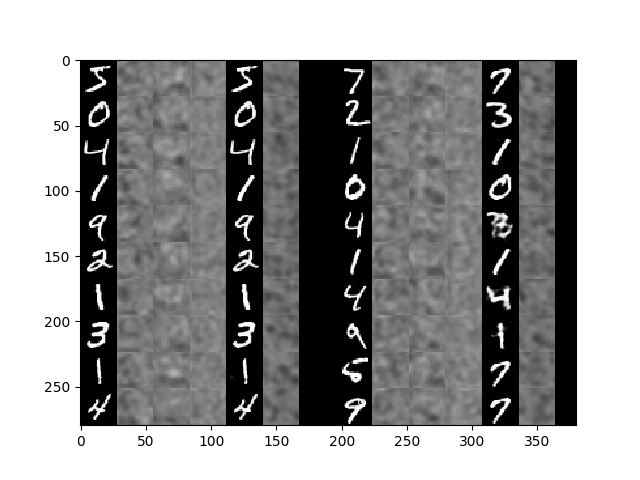

In [35]:
import matplotlib.pyplot as plt
import numpy
%matplotlib notebook

training_batch = next(iter(training_batches))
test_batch = next(iter(test_batches))

im = numpy.zeros((280,380))
for i in range(10):
    im[i*28:i*28+28,0:28] = Variable((training_batch))[i,0].data
    for j in range(5):
        im[i*28:i*28+28,(j+1)*28:(j+1)*28+28] = vaes[j][1](Variable((training_batch[i:i+1])))[0].data

for i in range(10):
    im[i*28:i*28+28,7*28:7*28+28] = Variable((test_batch))[i,0].data
    for j in range(5):
        im[i*28:i*28+28,(j+8)*28:(j+8)*28+28] = vaes[j][1](Variable((test_batch[i:i+1])))[0].data
        
plt.imshow(im, cmap="gray")

In [ ]:
import torch
from torchvision import datasets, transforms
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

In [ ]:
points = []
for data, labels in list(train_loader)[0:15]:
    s = vaes[0][1].encoder(Variable(data))
    for  point, label in zip(s[1].data.numpy(), labels):
        points.append((point, label))

In [ ]:
import pandas
df = pandas.DataFrame(points, columns=["point","label"])

In [ ]:
import matplotlib.pyplot as plt
import numpy
%matplotlib notebook
plt.xlim(-5,5)
colors = ["green","yellow","blue","orange","gray","red","black","purple","pink","brown"]
groups = df.groupby("label")
for key, group in groups:
    x=group["point"].apply(lambda x: x[0])
    y=group["point"].apply(lambda x: x[1])
    plt.plot(x,y,"o", color=colors[key])

In [90]:
from sklearn.metrics import silhouette_score
silhouette_score(numpy.array([list(point) for point in (df["point"])]), numpy.array(df["label"]))

0.1487785

In [11]:
from codes.utility.Misc import get_number_of_parameters

In [12]:
get_number_of_parameters(vae)

488073